# Alveoli and acinar size
This document is used to plot the acinar volumes and stereological counts for the alveolar manuscript.

First, we set up the notebook.

In [1]:
#Load the data and set up notebook
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import os
import pandas
import seaborn
import re

In [2]:
def get_git_hash():
    """
    Get the current git hash from the repository.
    Based on http://stackoverflow.com/a/949391/323100 and http://stackoverflow.com/a/18283905/323100
    """
    from subprocess import Popen, PIPE
    import os
    gitprocess = Popen(['git', '--git-dir', os.path.join(os.getcwd(), '.git'),
                        'rev-parse', '--short', '--verify', 'HEAD'],
                       stdout=PIPE)
    (output, _) = gitprocess.communicate()
    return output.strip().decode("utf-8")

In [3]:
the_current_git_hash = get_git_hash()
print('We are working with version %s of the analyis notebook' % the_current_git_hash)

We are working with version ca91cc0 of the analyis notebook


In [4]:
# Display defaults
plt.rc('image', cmap='gray', interpolation='nearest') # Display all images in b&w
plt.rcParams['figure.figsize'] = (16, 9)  # Size up figures a bit

Now we load the 'Count' data from Eveline.

In [5]:
# Load the data from this folder
RootPath = '/run/user/1000/gvfs/smb-share:server=nas.ana.unibe.ch,share=gruppe_schittny/Data/doc/David/'

In [6]:
# Get a list of *all* excel files that Eveline exported from the STEPanizer
# Based on https://stackoverflow.com/a/14798263
StepanizerFiles = sorted(glob.glob(os.path.join(RootPath, 'Eveline', '**/*.xls'), recursive=True))

In [7]:
# Generate an empty dataframe where we save the counts
Counts = pandas.DataFrame()

In [170]:
# Save the filename into the dataframe
Counts = pandas.DataFrame({'Location': StepanizerFiles})

In [171]:
# # Grab relevant data from filenames
# for f in StepanizerFiles:
#     print('Animal', os.path.basename(f).split('_R108C')[1].split('mrg-')[0][:3])
#     print('Day', os.path.basename(f).split('_R108C')[1].split('mrg-')[0][:2])
#     print('Acinus', os.path.basename(f).split('acinus')[1].split('_')[0])

In [172]:
Counts = pandas.DataFrame({'Location_Counts': StepanizerFiles})
Counts['Filename_Counts'] = [os.path.basename(f) for f in StepanizerFiles]
Counts['Animal'] = [os.path.basename(f).split('_R108C')[1].split('mrg-')[0][:3] for f in StepanizerFiles]
Counts['Day'] = [int(os.path.basename(f).split('_R108C')[1].split('mrg-')[0][:2]) for f in StepanizerFiles]
Counts['Acinus'] = [int(os.path.basename(f).split('acinus')[1].split('_')[0]) for f in StepanizerFiles]

In [173]:
# nr=16
# tmp=pandas.read_csv(StepanizerFiles[nr], nrows=13, delimiter='\t')
# # https://stackoverflow.com/a/31814158
# print('Eveline made', tmp['Total'][9], 'counts for', os.path.basename(StepanizerFiles[nr]))
# tmp

In [174]:
Counts['Counts'] = [int(pandas.read_csv(f, nrows=13, delimiter='\t')['Total'][10]) for f in StepanizerFiles]

In [175]:
Counts.head()

,Location_Counts,Filename_Counts,Animal,Day,Acinus,Counts
0,/run/user/1000/gvfs/smb-share:server=nas.ana.u...,_R108C04At-mrg-acinus11_2013-03-12_13-40_resul...,04A,4,11,11
1,/run/user/1000/gvfs/smb-share:server=nas.ana.u...,_R108C04At-mrg-acinus12_2013-03-12_15-10_resul...,04A,4,12,6
2,/run/user/1000/gvfs/smb-share:server=nas.ana.u...,_R108C04At-mrg-acinus16_2013-03-12_15-43_resul...,04A,4,16,26
3,/run/user/1000/gvfs/smb-share:server=nas.ana.u...,_R108C04At-mrg-acinus20_2013-03-12_16-01_resul...,04A,4,20,28
4,/run/user/1000/gvfs/smb-share:server=nas.ana.u...,_R108C04At-mrg-acinus21_2013-03-12_16-19_resul...,04A,4,21,16


In [176]:
Counts.tail()

,Location_Counts,Filename_Counts,Animal,Day,Acinus,Counts
286,/run/user/1000/gvfs/smb-share:server=nas.ana.u...,_R108C60Et-mrg-acinus08_2012-09-27_13-47_resul...,60E,60,8,385
287,/run/user/1000/gvfs/smb-share:server=nas.ana.u...,_R108C60Et-mrg-acinus11_2012-10-22_13-23_resul...,60E,60,11,369
288,/run/user/1000/gvfs/smb-share:server=nas.ana.u...,_R108C60Et-mrg-acinus12_2012-09-27_09-21_resul...,60E,60,12,472
289,/run/user/1000/gvfs/smb-share:server=nas.ana.u...,_R108C60Et-mrg-acinus13_2012-09-27_10-20_resul...,60E,60,13,320
290,/run/user/1000/gvfs/smb-share:server=nas.ana.u...,_R108C60Et-mrg-acinus14_2012-09-27_12-10_resul...,60E,60,14,540


In [177]:
# For D60, Eveline counted only half of the images, we thus double the counts for this day.
Counts.loc[Counts.Day == 60, 'Counts'] = 2*Counts['Counts']

In [178]:
Counts.tail()

,Location_Counts,Filename_Counts,Animal,Day,Acinus,Counts
286,/run/user/1000/gvfs/smb-share:server=nas.ana.u...,_R108C60Et-mrg-acinus08_2012-09-27_13-47_resul...,60E,60,8,770
287,/run/user/1000/gvfs/smb-share:server=nas.ana.u...,_R108C60Et-mrg-acinus11_2012-10-22_13-23_resul...,60E,60,11,738
288,/run/user/1000/gvfs/smb-share:server=nas.ana.u...,_R108C60Et-mrg-acinus12_2012-09-27_09-21_resul...,60E,60,12,944
289,/run/user/1000/gvfs/smb-share:server=nas.ana.u...,_R108C60Et-mrg-acinus13_2012-09-27_10-20_resul...,60E,60,13,640
290,/run/user/1000/gvfs/smb-share:server=nas.ana.u...,_R108C60Et-mrg-acinus14_2012-09-27_12-10_resul...,60E,60,14,1080


In [179]:
print('We have %s acini which Eveline assessed with the STEPanizer' % len(Counts))

We have 291 acini which Eveline assessed with the STEPanizer


In [180]:
# Let's get a quick overview of the data
Counts.groupby(by=['Day', 'Animal'])['Counts'].describe()

count        mean         std    min     25%    50%     75%  \
Day Animal                                                                
4   04A      56.0   25.089286   23.150320    3.0    9.75   16.0   32.75   
    04B      23.0   65.043478   43.849410   15.0   34.50   53.0   80.00   
    04C      51.0   60.509804   45.424387   10.0   29.50   52.0   77.00   
10  10A      27.0   77.851852   56.305283   18.0   28.50   69.0  122.00   
    10B      14.0   84.571429   65.752115   23.0   37.50   52.0  135.25   
    10C      17.0  108.764706  125.449955   15.0   46.00   73.0  105.00   
21  21B      14.0  208.142857  197.709133   35.0   72.00  160.5  237.00   
    21D      15.0  181.133333  109.368882   50.0   90.00  167.0  253.50   
    21E      11.0  323.090909  145.936599  108.0  218.00  298.0  434.50   
60  60B      24.0  701.750000  230.946116  322.0  506.50  728.0  849.00   
    60C      20.0  207.600000  120.227153   60.0  136.00  172.0  254.00   
    60D      10.0  727.400000  198.946224  444.0  598.50  737.0  780.00   
    60E       9.0  791.555556  268.917790  272.0  736.00  740.0  944.00   

               max  
Day Animal          
4   04A      111.0  
    04B      171.0  
    04C      249.0  
10  10A      245.0  
    10B      199.0  
    10C      505.0  
21  21B      781.0  
    21D      379.0  
    21E      572.0  
60  60B     1296.0  
    60C      540.0  
    60D     1182.0  
    60E     1204.0

In [181]:
# Set ourselves a palette, based on the individual unique sample names
# The dictionary palette setting is based on the comments in https://stackoverflow.com/q/36554075/323100
ourcolors=seaborn.color_palette('deep', len(pandas.unique(Counts.Animal)))
ourpalette = {animal:ourcolors[c] for c, animal in enumerate(pandas.unique(Counts.Animal))}

In [182]:
# Set indivdual measurement color (in dataframe)
Counts['Color'] = [None] * len(Counts)
for c,animal in enumerate(Counts.Animal):
    for d,i in enumerate(pandas.unique(Counts.Animal)):
        if animal == i:
            Counts.set_value(c, 'Color', ourcolors[d])

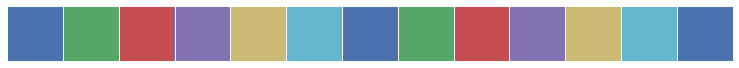

In [183]:
seaborn.palplot(ourcolors)

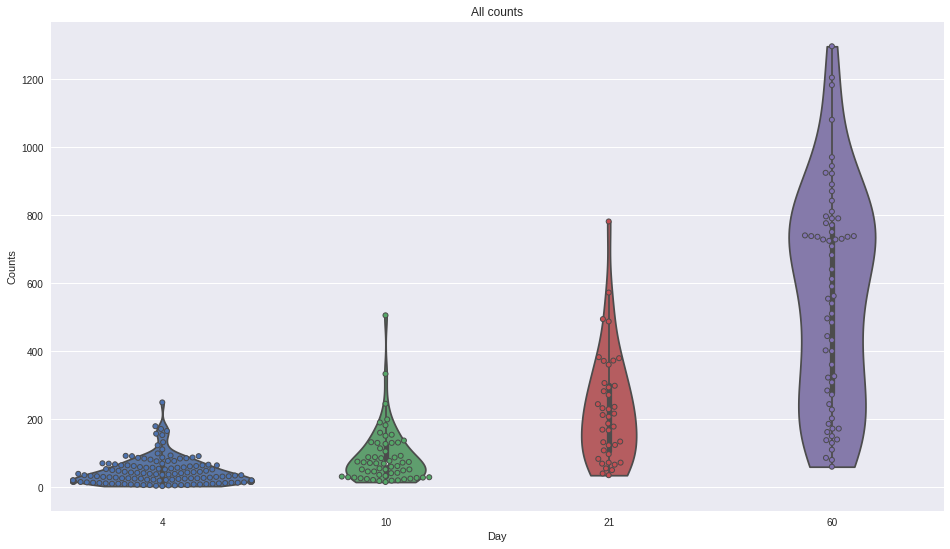

In [184]:
seaborn.violinplot(data=Counts, x='Day', y='Counts', cut=0, scale='count',
               palette=seaborn.color_palette('deep', len(pandas.unique(Counts.Day))))
seaborn.swarmplot(data=Counts, x='Day', y='Counts', split=False, linewidth=1,
              palette=seaborn.color_palette('deep', len(pandas.unique(Counts.Day))))
plt.title('All counts')
plt.show()

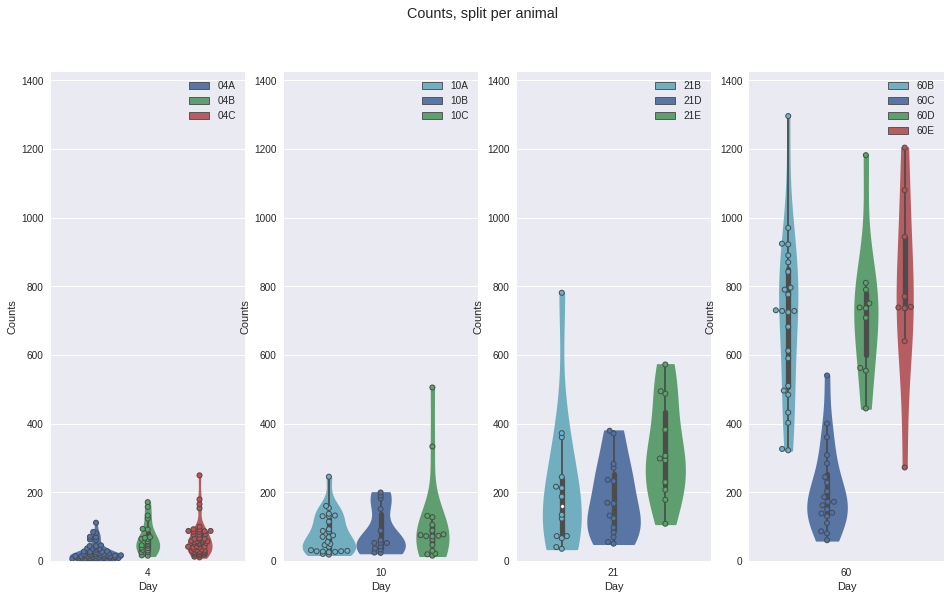

In [148]:
for c,d in enumerate(pandas.unique(Counts.Day)):
    plt.subplot(1,len(pandas.unique(Counts.Day)),c+1)
    bxplt = seaborn.violinplot(data=Counts.loc[Counts.Day == d], x='Day', y='Counts',
                           hue='Animal', palette=ourpalette, cut=0, inner='box')
    swrmplt = seaborn.swarmplot(data=Counts.loc[Counts.Day == d], x='Day', y='Counts', hue='Animal',
                            split=True, linewidth=1, palette=ourpalette)
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.ylim([0,1.1*Counts.Counts.max()])
    bxplt.legend(handles[:len(handles)//2], labels[:len(labels)//2])
plt.suptitle('Counts, split per animal')
plt.show()

Let's now load the volume data.

First directly from `anatera4`, where I originally exported the DICOM files from MeVisLab

In [24]:
terastation = '/run/user/1000/gvfs/smb-share:server=anatera4,share=share/SLS/'

In [25]:
import timeit
# tic=timeit.default_timer()
# # Do Stuff
# toc=timeit.default_timer()
# toc - tic #elapsed time in seconds

In [26]:
# Get a list of *all* DICOM files that I exported aeons ago
# Based on https://stackoverflow.com/a/14798263
tic=timeit.default_timer()
AcinarVolumeFiles_glob = sorted(glob.glob(os.path.join(terastation, '**/R108*.dcm'), recursive=True))
toc=timeit.default_timer()
print('The whole process took %s minutes' % round(float((toc - tic)/60.),2))
print('We found %s DICOM files' % len(AcinarVolumeFiles_glob))

The whole process took 36.56 minutes
We found 824 DICOM files


In [ ]:
AcinarVolumeFiles = []
tic=timeit.default_timer()
# Iterate through all the files, based on from https://www.quora.com/Whats-the-easiest-way-to-recursively-get-a-list-of-all-the-files-in-a-directory-tree-in-Python/answer/Vaibhav-Mallya
for root, directories, filenames in os.walk(terastation):
    for filename in filenames:
        if '.dcm' in filename:
            AcinarVolumeFiles.append(os.path.join(root,filename))
        print('Scanning: %s' % filename, 25*' ', end='\r')
toc=timeit.default_timer()
print('The whole process took %s minutes' % round(float((toc - tic)/60.),2))
print('We found %s DICOM files' % len(AcinarVolumeFiles))
AcinarVolumeFiles.sort()  # Force the list to be sorted, for convenience

In [70]:
## TEMPORARY ##
# Append all R108 entries to a list, count to see what we have on top of R108...
tmp = []
for i in AcinarVolumeFiles_glob:
    if 'R108' not in i:
        tmp.append(i)
print('%s files from "AcinarVolumeFiles" were not found in "AcinarVolumeFiles_glob"' % len(tmp))
for i in tmp:
    print(os.path.basename(i))

0 files from "AcinarVolumeFiles" were not found in "AcinarVolumeFiles_glob"


In [74]:
# See the difference between those two methods
# Based on https://stackoverflow.com/a/3462164/323100
print('"AcinarVolumeFiles" contains %s files' % len(AcinarVolumeFiles))
print('"AcinarVolumeFiles_glob" contains %s files' % len(AcinarVolumeFiles_glob))
MethodDifference = [item for item in AcinarVolumeFiles if item not in AcinarVolumeFiles_glob]
print('Here are the %s files which are different' % len(MethodDifference))
for c,i in enumerate(MethodDifference):
    print('%02s: %s' % (c+1,os.path.basename(i)))

"AcinarVolumeFiles" contains 847 files
"AcinarVolumeFiles_glob" contains 811 files
Here are the 36 files which are different
 1: ROIx114-146y98-130z181-213.Threshold.dcm
 2: ROIx114-146y98-130z181-213.dcm
 3: M251-090S7.1024.1024.1024.gvr.acinus10.vx5.92um.vol0.025495ul.dcm
 4: M251-090S7.1024.1024.1024.gvr.acinus10.vx5.92um.vol0.025495ul.dcm.histogram.txt
 5: M251-090S7.1024.1024.1024.gvr.acinus11.vx5.92um.vol0.004943ul.dcm
 6: M251-090S7.1024.1024.1024.gvr.acinus11.vx5.92um.vol0.004943ul.dcm.histogram.txt
 7: M251-090S7.1024.1024.1024.gvr.acinus12.vx5.92um.vol0.005507ul.dcm
 8: M251-090S7.1024.1024.1024.gvr.acinus12.vx5.92um.vol0.005507ul.dcm.histogram.txt
 9: M251-090S7.1024.1024.1024.gvr.acinus13.vx5.92um.vol0.004102ul.dcm
10: M251-090S7.1024.1024.1024.gvr.acinus13.vx5.92um.vol0.004102ul.dcm.histogram.txt
11: M251-090S7.1024.1024.1024.gvr.acinus7.vx5.92um.vol0.023886ul.dcm
12: M251-090S7.1024.1024.1024.gvr.acinus7.vx5.92um.vol0.023886ul.dcm.histogram.txt
13: M251-090S7.1024.1024.10

In [38]:
# Generate an empty dataframe where we save the volumes
VolumesFromDisk = pandas.DataFrame()

In [122]:
# sorted(AcinarVolumeFiles_glob)[:5]

['/run/user/1000/gvfs/smb-share:server=anatera4,share=share/SLS/2009f/mrg/R108C21A2t-mrg/R108C21A2t-mrg.2240.2940.1024.gvr.acinus1.volume0.018193666.pixelsize0.00148000009357929.dcm',
 '/run/user/1000/gvfs/smb-share:server=anatera4,share=share/SLS/2009f/mrg/R108C21A2t-mrg/R108C21A2t-mrg.2240.2940.1024.gvr.acinus11.volume0.019022319.pixelsize0.00148000009357929.dcm',
 '/run/user/1000/gvfs/smb-share:server=anatera4,share=share/SLS/2009f/mrg/R108C21A2t-mrg/R108C21A2t-mrg.2240.2940.1024.gvr.acinus12.volume0.0827903.pixelsize0.00148000009357929.dcm',
 '/run/user/1000/gvfs/smb-share:server=anatera4,share=share/SLS/2009f/mrg/R108C21A2t-mrg/R108C21A2t-mrg.2240.2940.1024.gvr.acinus16.volume0.030999836.pixelsize0.00148000009357929.dcm',
 '/run/user/1000/gvfs/smb-share:server=anatera4,share=share/SLS/2009f/mrg/R108C21A2t-mrg/R108C21A2t-mrg.2240.2940.1024.gvr.acinus17.volume0.086996235.pixelsize0.00148000009357929.dcm']

In [75]:
# Save the filename into the dataframe
VolumesFromDisk = pandas.DataFrame({'Location': AcinarVolumeFiles_glob})

In [224]:
# # Grab relevant data from filenames
# for f in AcinarVolumeFiles_glob:
#     print(os.path.basename(f))
#     print('Animal', os.path.basename(f).split('R108C')[1].split('mrg.')[0][:-2])
#     print('Day', os.path.basename(f).split('R108C')[1].split('mrg')[0][:2])
#     print('Acinus', os.path.basename(f).split('.acinus')[1].split('.volume')[0])
#     print('Volume', os.path.basename(f).split('.volume')[1].split('.pixelsize')[0])
#     print('Scantime', os.path.dirname(f).split('/SLS/')[1].split('/')[0])
#     print(80*'-')

R108C21A2t-mrg.2240.2940.1024.gvr.acinus1.volume0.018193666.pixelsize0.00148000009357929.dcm
Scantime 2009f
R108C21A2t-mrg.2240.2940.1024.gvr.acinus11.volume0.019022319.pixelsize0.00148000009357929.dcm
Scantime 2009f
R108C21A2t-mrg.2240.2940.1024.gvr.acinus12.volume0.0827903.pixelsize0.00148000009357929.dcm
Scantime 2009f
R108C21A2t-mrg.2240.2940.1024.gvr.acinus16.volume0.030999836.pixelsize0.00148000009357929.dcm
Scantime 2009f
R108C21A2t-mrg.2240.2940.1024.gvr.acinus17.volume0.086996235.pixelsize0.00148000009357929.dcm
Scantime 2009f
R108C21A2t-mrg.2240.2940.1024.gvr.acinus18.volume0.038363531.pixelsize0.00148000009357929.dcm
Scantime 2009f
R108C21A2t-mrg.2240.2940.1024.gvr.acinus19.volume0.079894781.pixelsize0.00148000009357929.dcm
Scantime 2009f
R108C21A2t-mrg.2240.2940.1024.gvr.acinus20.volume0.063512988.pixelsize0.00148000009357929.dcm
Scantime 2009f
R108C21A2t-mrg.2240.2940.1024.gvr.acinus21.volume0.14445718.pixelsize0.00148000009357929.dcm
Scantime 2009f
R108C21A2t-mrg.2240.294

Scantime 2010a
R108C60C_B1-mrg.2934x2934x1024.gvr.acinus18.volume0.013195808.pixelsize0.00148000009357929.dcm
Scantime 2010a
R108C60C_B1-mrg.2934x2934x1024.gvr.acinus19.volume0.0060889684.pixelsize0.00148000009357929.dcm
Scantime 2010a
R108C60C_B1-mrg.2934x2934x1024.gvr.acinus2.volume0.052034456.pixelsize0.00148000009357929.dcm
Scantime 2010a
R108C60C_B1-mrg.2934x2934x1024.gvr.acinus20.volume0.017161064.pixelsize0.00148000009357929.dcm
Scantime 2010a
R108C60C_B1-mrg.2934x2934x1024.gvr.acinus21.volume0.025440967.pixelsize0.00148000009357929.dcm
Scantime 2010a
R108C60C_B1-mrg.2934x2934x1024.gvr.acinus23.volume0.015027809.pixelsize0.00148000009357929.dcm
Scantime 2010a
R108C60C_B1-mrg.2934x2934x1024.gvr.acinus24.volume0.031099426.pixelsize0.00148000009357929.dcm
Scantime 2010a
R108C60C_B1-mrg.2934x2934x1024.gvr.acinus28.volume0.075263329.pixelsize0.00148000009357929.dcm
Scantime 2010a
R108C60C_B1-mrg.2934x2934x1024.gvr.acinus29.volume0.13059497.pixelsize0.00148000009357929.dcm
Scantime 20

In [149]:
# # Some names (see output of this cell) derive from the R108C$Day$$Animal$ scheme.
# # We catch them with the intricate .split() in the cells below...
# for i in VolumesFromDisk.File:
#     if len(i.split('mrg')[0][len('R108C'):-2]) >3:
#         tmp.append(i.split('mrg')[0][len('R108C'):-2])
# for i in pandas.unique(tmp):
#     print(i)

In [225]:
VolumesFromDisk = pandas.DataFrame({'Location': AcinarVolumeFiles_glob})
VolumesFromDisk['File'] = [os.path.basename(f) for f in AcinarVolumeFiles_glob]
VolumesFromDisk['Animal'] = [os.path.basename(f).split('mrg')[0][len('R108C'):len('R108C')+3]
                             for f in AcinarVolumeFiles_glob]
VolumesFromDisk['Scantime'] = [os.path.dirname(f).split('/SLS/')[1].split('/')[0]
                          for f in AcinarVolumeFiles_glob]
VolumesFromDisk['Day'] = [int(os.path.basename(f).split('mrg')[0][len('R108C'):len('R108C')+2])
                          for f in AcinarVolumeFiles_glob]
VolumesFromDisk['Acinus'] = [int(os.path.basename(f).split('.acinus')[1].split('.volume')[0])
                             for f in AcinarVolumeFiles_glob]
VolumesFromDisk['Volume'] = [float(os.path.basename(f).split('.volume')[1].split('.pixelsize')[0])
                             for f in AcinarVolumeFiles_glob]

In [226]:
print('We have %s acini where we got the volumes' % len(VolumesFromDisk))

We have 811 acini where we got the volumes


In [227]:
VolumesFromDisk.groupby(by=['Day', 'Animal'])['Volume'].describe()

count      mean       std       min       25%       50%       75%  \
Day Animal                                                                      
4   04A      51.0  0.005778  0.005166  0.000918  0.002298  0.003587  0.007537   
    04B      23.0  0.035109  0.034599  0.006500  0.013876  0.022904  0.034274   
    04C      51.0  0.028898  0.024524  0.004333  0.012543  0.023724  0.038294   
    04D      44.0  0.024475  0.023928  0.003994  0.009371  0.016748  0.027254   
    04E      43.0  0.011132  0.009397  0.001216  0.004316  0.009308  0.012664   
10  10A      32.0  0.017683  0.011906  0.002228  0.006594  0.014849  0.025849   
    10B      27.0  0.017440  0.014117  0.003091  0.005615  0.013327  0.020489   
    10C      69.0  0.028546  0.034399  0.001266  0.007853  0.015728  0.035606   
    10D      34.0  0.019566  0.012316  0.005223  0.012436  0.015605  0.025856   
    10E      33.0  0.010937  0.007567  0.002034  0.005457  0.007357  0.017192   
21  21A      24.0  0.043471  0.036621  0.003041  0.018055  0.029545  0.065106   
    21B      42.0  0.046559  0.037820  0.006527  0.018710  0.039733  0.057297   
    21D      94.0  0.068710  0.082583  0.001512  0.020657  0.034159  0.082559   
    21E      51.0  0.078594  0.067957  0.007258  0.035371  0.061948  0.103770   
36  36A      30.0  0.098864  0.098033  0.011037  0.037088  0.081224  0.110725   
    36C      54.0  0.105851  0.075128  0.013257  0.051933  0.082114  0.134093   
    36D      25.0  0.114701  0.081199  0.024564  0.065642  0.094099  0.163553   
60  60B      24.0  0.319332  0.132694  0.133954  0.224747  0.306324  0.426902   
    60C      41.0  0.039036  0.029254  0.005616  0.018427  0.029921  0.045526   
    60D      10.0  0.434013  0.128309  0.232298  0.322434  0.440845  0.545049   
    60E       9.0  0.459532  0.225806  0.124868  0.337419  0.511632  0.670989   

                 max  
Day Animal            
4   04A     0.021516  
    04B     0.120925  
    04C     0.134680  
    04D     0.108391  
    04E     0.046470  
10  10A     0.049147  
    10B     0.051696  
    10C     0.171791  
    10D     0.053397  
    10E     0.030101  
21  21A     0.144457  
    21B     0.215823  
    21D     0.393451  
    21E     0.347160  
36  36A     0.522053  
    36C     0.394578  
    36D     0.381259  
60  60B     0.667457  
    60C     0.130595  
    60D     0.590029  
    60E     0.752025

In [228]:
# Update palette, since we might have more animals than what we had above in cell 19
ourcolors=seaborn.color_palette('deep', len(pandas.unique(VolumesFromDisk.Animal)))
ourpalette = {animal:ourcolors[c] for c, animal in enumerate(sorted(pandas.unique(VolumesFromDisk.Animal)))}

In [229]:
# for c,d in enumerate(sorted(pandas.unique(VolumesFromDisk.Day))):
#     print(d)
#     print(pandas.unique(VolumesFromDisk.loc[VolumesFromDisk.Day == d]['Animal']))

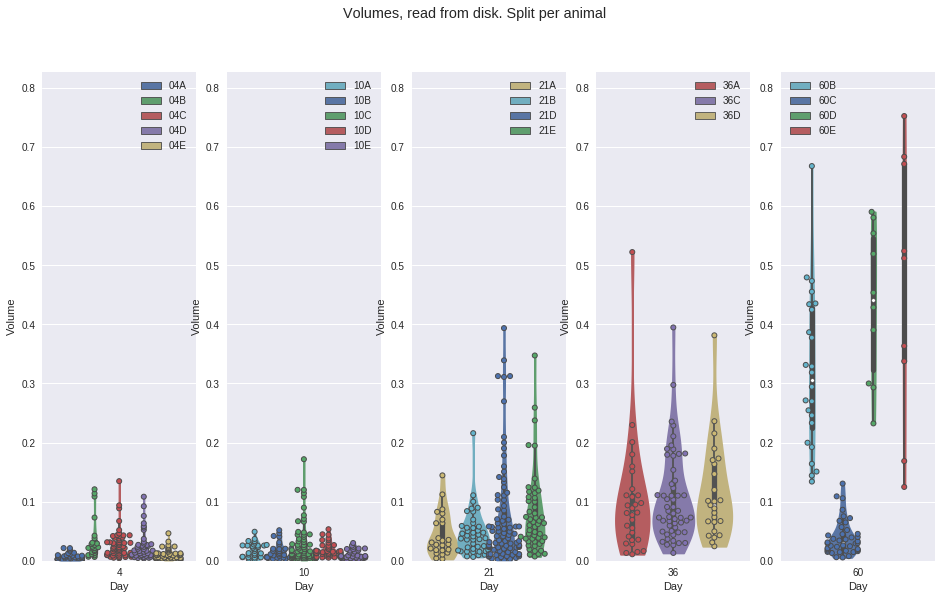

In [230]:
for c,d in enumerate(sorted(pandas.unique(VolumesFromDisk.Day))):
    plt.subplot(1,len(pandas.unique(VolumesFromDisk.Day)),c+1)
    bxplt = seaborn.violinplot(data=VolumesFromDisk.loc[VolumesFromDisk.Day == d], x='Day', y='Volume',
                               hue='Animal',
                               # Because the animals are preferentially sorted on the beamtime name, we have
                               # to jump through the hoop below and sort the hues on the 'Animal' in addition
                               # to what we did for Evelines counts where all the data is in *one* folder
                               # Just comment the line to see the difference (a correct plot, but ugly sort :)
                               hue_order=sorted(pandas.unique(VolumesFromDisk.loc[VolumesFromDisk.Day == d]['Animal'])),
                               palette=ourpalette, cut=0, inner='box')
    swrmplt = seaborn.swarmplot(data=VolumesFromDisk.loc[VolumesFromDisk.Day == d], x='Day', y='Volume',
                                hue='Animal',
                                hue_order=sorted(pandas.unique(VolumesFromDisk.loc[VolumesFromDisk.Day == d]['Animal'])),
                                split=True, linewidth=1, palette=ourpalette)
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.ylim([0,1.1*VolumesFromDisk.Volume.max()])
    bxplt.legend(handles[:len(handles)//2], labels[:len(labels)//2])
plt.suptitle('Volumes, read from disk. Split per animal')
plt.show()

Now we 'just' have to concatenate the two dataframes :)

In [232]:
# Merge the dataframes: http://pandas.pydata.org/pandas-docs/stable/merging.html
# This seems to discard all entries that are *not* found in both df's
print('\n\nTODO: confirm values by randomly sampling some file names and Count XLS sheets\n\n')
Merged = pandas.merge(Counts, VolumesFromDisk)



TODO: confirm values by randomly sampling some file names and Count XLS sheets




In [233]:
Merged['CpV'] = Merged['Counts']/Merged['Volume']

In [234]:
# Doublecheck
import numpy.random
for i in range(3):
    print(80*'-')
    print(Merged.loc[numpy.random.randint(len(Merged))].to_dense())

--------------------------------------------------------------------------------
Location_Counts    /run/user/1000/gvfs/smb-share:server=nas.ana.u...
Filename_Counts    _R108C04Bt-mrg-acinus11_2013-04-10_14-57_resul...
Animal                                                           04B
Day                                                                4
Acinus                                                            11
Counts                                                            64
Color              (0.3333333333333333, 0.6588235294117647, 0.407...
Location           /run/user/1000/gvfs/smb-share:server=anatera4,...
File               R108C04Bt-mrg.2932x2932x1024.gvr.acinus11.volu...
Scantime                                                       2010a
Volume                                                     0.0164351
CpV                                                           3894.1
Name: 57, dtype: object
-------------------------------------------------------------------

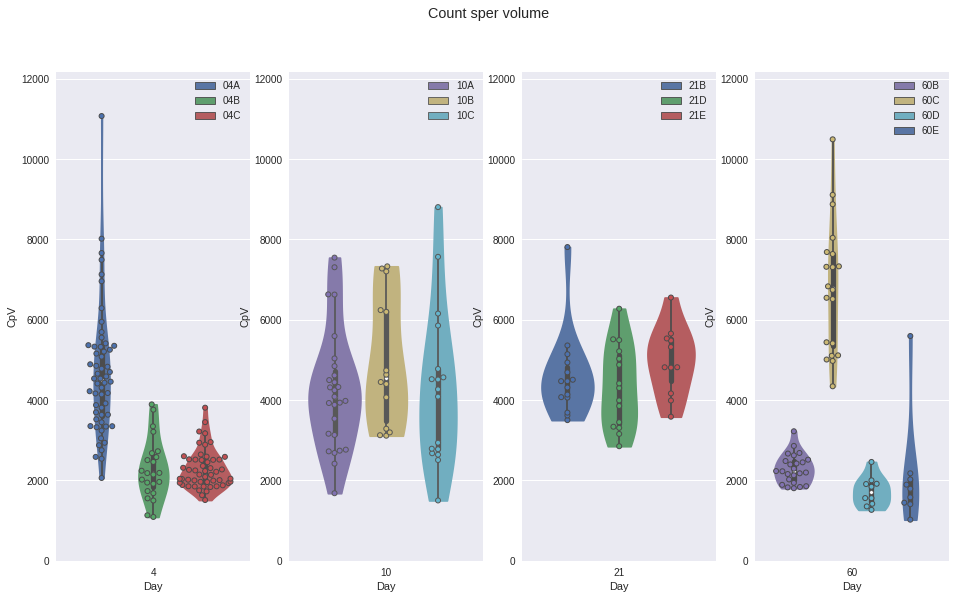

In [202]:
for c,d in enumerate(sorted(pandas.unique(Merged.Day))):
    plt.subplot(1,len(pandas.unique(Merged.Day)),c+1)
    bxplt = seaborn.violinplot(data=Merged.loc[Merged.Day == d], x='Day', y='CpV',
                               hue='Animal',
                               hue_order=sorted(pandas.unique(Merged.loc[Merged.Day == d]['Animal'])),
                               palette=ourpalette, cut=0, inner='box')
    swrmplt = seaborn.swarmplot(data=Merged.loc[Merged.Day == d], x='Day', y='CpV',
                                hue='Animal',
                                hue_order=sorted(pandas.unique(Merged.loc[Merged.Day == d]['Animal'])),
                                split=True, linewidth=1, palette=ourpalette)
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.ylim([0,1.1*Merged.CpV.max()])
    bxplt.legend(handles[:len(handles)//2], labels[:len(labels)//2])
plt.suptitle('Count sper volume')
plt.show()

----

The stuff below is from an old version of the [Jupyter notebook](http://jupyter.org), please disregard it for the moment...

----


Johannes also compiled a list of the volumes and saved them in an XLS file.
Let's load that, so that we can compare...

In [ ]:
# Read Volume data from Johannes' XLS-sheet
Volumes = pandas.read_excel(pandas.ExcelFile(os.path.join(RootPath, 'JCS', 'Acinarvol-JCS171122.xlsx'), sheet='Acinarvol'),
                        skiprows=19)


In [ ]:
# Drop the 'Unnamed' colums
Volumes.drop(list(Volumes.filter(regex='Unnamed')), axis=1, inplace=True)
# Drop the unnecessary columns
Volumes.drop('4.5', axis=1, inplace=True)
Volumes.drop('60.4', axis=1, inplace=True)

In [ ]:
# The data looks like that
Volumes.head()

In [ ]:
# Replace the column names to something meaningful
# Use some `regular expression` https://www.regular-expressions.info/anchors.html
Volumes.rename(columns=lambda x: re.sub('^4', '04', str(x)), inplace=True)
Volumes.rename(columns=lambda x: re.sub('\.1$', 'B', str(x)), inplace=True)
Volumes.rename(columns=lambda x: re.sub('\.2$', 'C', str(x)), inplace=True)
Volumes.rename(columns=lambda x: re.sub('\.3$', 'D', str(x)), inplace=True)
Volumes.rename(columns=lambda x: re.sub('\.4$', 'E', str(x)), inplace=True)
# https://stackoverflow.com/a/31697086/323100
Volumes.rename(columns=lambda x: re.sub(r'\b04\b', '04A', str(x)), inplace=True)
Volumes.rename(columns=lambda x: re.sub(r'\b10\b', '10A', str(x)), inplace=True)
Volumes.rename(columns=lambda x: re.sub(r'\b21\b', '21A', str(x)), inplace=True)
Volumes.rename(columns=lambda x: re.sub(r'\b36\b', '36A', str(x)), inplace=True)
Volumes.rename(columns=lambda x: re.sub(r'\b60\b', '60A', str(x)), inplace=True)

In [ ]:
Volumes.head()

In [ ]:
# Generate a color palette to distinguish between postnatal days
daycolor = [None] * len(Volumes.columns.values)
day = [None] * len(Volumes.columns.values)
for c,i in enumerate(Volumes.columns.values):
    if int(i[:-1])==4:
        day[c] = '04'
        daycolor[c] = seaborn.color_palette()[0]
    elif int(i[:-1])==10:
        day[c] = '10'
        daycolor[c] = seaborn.color_palette()[1]
    elif int(i[:-1])==21:
        day[c] = '21'
        daycolor[c] = seaborn.color_palette()[2]
    elif int(i[:-1])==36:
        day[c] = '36'
        daycolor[c] = seaborn.color_palette()[3]
    else:
        day[c] = '60'
        daycolor[c] = seaborn.color_palette()[4]

In [ ]:
# Plot the volume data
seaborn.violinplot(data=Volumes, cut=0, width=1, scale='count', palette=daycolor)
seaborn.swarmplot(data=Volumes, alpha=0.618, linewidth=1, palette=daycolor)
plt.title("Volumes from Johannes' XLS file")
plt.show()

In [ ]:
Volumes.describe()

# Bridges
Eveline also counted the [*bridges*](http://www.stereology.info/connectivity/) in the datasets.
Tiziana cleaned this data up and saved it to an Excel file (`acini merge.xlsx`).
We've made the file a bit more consistent (removing empty columns and rows, naming columns consistently, etc.) and work with this file (`acini merge_edit.xlsx`) below.

Below we load this file and calculate the number of acini according to [our paper for day 60](http://jap.physiology.org/content/115/9/1379).
The calculation for this paper was done in [MATLAB](https://www.mathworks.com/products/matlab.html)/[R](https://www.r-project.org/), nowadays I'm more handy with Python...

I was not able to find the original calculation script on the ana.unibe.ch network drives, but I seem to have saved a copy of the calculation and insertion to the [LaTeX](https://www.latex-project.org/) manuscript file in a *very* old [GitHub repository here](https://github.com/habi/AcinusPaperCode/blob/master/AcinarSize/ReadVolumeSurfaceAndAlveaolarNumber.py).

In [ ]:
DataFile = pandas.ExcelFile('acini merge_edit.xlsx')
print('The excel file contains the sheets:', end=' ')
for i in DataFile.sheet_names:
    print(i,end=', ')

In [ ]:
# Read the single sheets of the XLS file each into a dataframe
D04 = DataFile.parse(DataFile.sheet_names[0])
D10 = DataFile.parse(DataFile.sheet_names[1])
D21 = DataFile.parse(DataFile.sheet_names[2])
D60 = DataFile.parse(DataFile.sheet_names[3])

In [ ]:
# Rename 'Counts.' to 'Counts..0' (we use the Counts. counter later on)
D04.rename(columns={'Counts':'Counts.0'}, inplace=True)
D10.rename(columns={'Counts':'Counts.0'}, inplace=True)
D21.rename(columns={'Counts':'Counts.0'}, inplace=True)
D60.rename(columns={'Counts':'Counts.0'}, inplace=True)

In [ ]:
# For D60, Eveline counted only half of the images, we thus double the counts for this day.
print('Original D60')
print(D60.head())
for i in range(3):
    D60.iloc[:,2*i+1] =  D60.iloc[:,2*i+1] * 2
print('\nDouble the counts for D60')    
print(D60.head())    

We plot the data as [notched](https://en.wikipedia.org/wiki/Box_plot#Variations) boxplots.
The notches give a rough guide to the significance of difference of medians; if the notches of two boxes do not overlap, this offers evidence of a statistically significant difference between the medians.
On top of the boxplots we do a jittered scatterplot of the datapoints, to see the distribution of the data points.

In [ ]:
#Plot the 'counts' from Eveline
upper_limit=1350
plt.subplot(141)
seaborn.boxplot(data=D04.iloc[:,[1,3,5]], color=seaborn.color_palette()[0], notch=True)
seaborn.swarmplot(data=D04.iloc[:,[1,3,5]], color=seaborn.color_palette()[0], size=10, facecolor='k', linewidth=1, alpha=0.5)
plt.ylim([0,upper_limit])
plt.xticks(range(3), [list(D04)[0], list(D04)[2], list(D04)[4]])
plt.title('Counts. D04')
plt.subplot(142)
seaborn.boxplot(data=D10.iloc[:,[1,3,5]], color=seaborn.color_palette()[1], notch=True)
seaborn.swarmplot(data=D10.iloc[:,[1,3,5]], color=seaborn.color_palette()[1], size=10, facecolor='k', linewidth=1, alpha=0.5)
plt.ylim([0,upper_limit])
plt.xticks(range(3), [list(D10)[0], list(D10)[2], list(D10)[4]])
plt.title('Counts. D10')
plt.subplot(143)
seaborn.boxplot(data=D21.iloc[:,[1,3,5]], color=seaborn.color_palette()[2], notch=True)
seaborn.swarmplot(data=D21.iloc[:,[1,3,5]], color=seaborn.color_palette()[2], size=10, facecolor='k', linewidth=1, alpha=0.5)
plt.ylim([0,upper_limit])
plt.xticks(range(3), [list(D21)[0], list(D21)[2], list(D21)[4]])
plt.title('Counts. D21')
plt.subplot(144)
seaborn.boxplot(data=D60.iloc[:,[1,3,5]], color=seaborn.color_palette()[4], notch=True)
seaborn.swarmplot(data=D60.iloc[:,[1,3,5]], color=seaborn.color_palette()[4], size=10, facecolor='k', linewidth=1, alpha=0.5)
plt.ylim([0,upper_limit])
plt.xticks(range(3), [list(D60)[0], list(D60)[2], list(D60)[4]])
plt.title('Counts. D60')
plt.show()

In [ ]:
# Divide the volume by the counts, add this as a column to the dataframes
for i in range(3):
    D04['Ratio.%s' % i] =  D04.iloc[:,2*i+1]/D04.iloc[:,2*i]
    D10['Ratio.%s' % i] =  D10.iloc[:,2*i+1]/D10.iloc[:,2*i]
    D21['Ratio.%s' % i] =  D21.iloc[:,2*i+1]/D21.iloc[:,2*i]
    D60['Ratio.%s' % i] =  D60.iloc[:,2*i+1]/D60.iloc[:,2*i]

In [ ]:
D04.head()

In [ ]:
D10.head()

In [ ]:
D21.head()

In [ ]:
D60.head()

In [ ]:
# Plot the 'count per volume' ratio
upper_limit = 9e3
plt.subplot(141)
seaborn.boxplot(data=D04.iloc[:,[6,7,8]], color=seaborn.color_palette()[0], notch=True)
seaborn.swarmplot(data=D04.iloc[:,[6,7,8]], color=seaborn.color_palette()[0], size=10, facecolor='k', linewidth=1, alpha=0.5)
plt.ylim([0,upper_limit])
plt.xticks(range(3), [list(D04)[0], list(D04)[2], list(D04)[4]])
plt.title('Counts. per volume D04')
plt.subplot(142)
seaborn.boxplot(data=D10.iloc[:,[6,7,8]], color=seaborn.color_palette()[1], notch=True)
seaborn.swarmplot(data=D10.iloc[:,[6,7,8]], color=seaborn.color_palette()[1], size=10, facecolor='k', linewidth=1, alpha=0.5)
plt.ylim([0,upper_limit])
plt.xticks(range(3), [list(D10)[0], list(D10)[2], list(D10)[4]])
plt.title('Counts. per volume D10')
plt.subplot(143)
seaborn.boxplot(data=D21.iloc[:,[6,7,8]], color=seaborn.color_palette()[2], notch=True)
seaborn.swarmplot(data=D21.iloc[:,[6,7,8]], color=seaborn.color_palette()[2], size=10, facecolor='k', linewidth=1, alpha=0.5)
plt.ylim([0,upper_limit])
plt.xticks(range(3), [list(D21)[0], list(D21)[2], list(D21)[4]])
plt.title('Counts. per volume D21')
plt.subplot(144)
seaborn.boxplot(data=D60.iloc[:,[6,7,8]], color=seaborn.color_palette()[4], notch=True)
seaborn.swarmplot(data=D60.iloc[:,[6,7,8]], color=seaborn.color_palette()[4], size=10, facecolor='k', linewidth=1, alpha=0.5)
plt.ylim([0,upper_limit])
plt.xticks(range(3), [list(D60)[0], list(D60)[2], list(D60)[4]])
plt.title('Counts. per volume D60')
plt.show()

In [ ]:
# Setup (copied verbatim from (ReadVolumeSurfaceAndAlveaolarNumber.py)
TOMCATVoxelSize = 1.48
SliceNumber = 10  # every $SliceNumber slice was exported, thus needed for scaling 
DisectorThickness = 5 # slices
ShrinkageFactor = 0.61 # Volume-Shrinkage-Factor = 61% with STD=5, calculated by Sébastien: Volume TOMCAT / Waterdisplacement

In [ ]:
# Hsiah2010 p. 407:
# Counting the number of entrance rings in paired sections by the disector
# technique allows estimation of total number of alveoli in the lung N(a,L) (112, 113).
# N(a,L) is the product of the number of alveolar openings per unit parenchyma
# volume (Sn/Vp) with the volume density of parenchyma per unit lung volume VV(p,L)
# and the absolute lung volume:
# N(a,L,) = (Sn/Vp) * VV(p,L) * V(L) (Formula 17)

In [ ]:
# We need the 'Area_Vol' from the STEPanizer-Files, it's in the line where we have 'a(p)'
# Area_Vol = double(line[1])*STEPanizerPixelSize_Vol**2
# We need the STEPanizer pixel size, it's in the line where we have 'Pixel size'
STEPanizerPixelSize_Vol = 3.
print('GET CORRECT AREA_VOL')
Area_Vol = 2. * STEPanizerPixelSize_Vol**2
AcinusTestPoints = 15


# Volume = AcinusTestPoints * Area_Vol * STEPanizerPixelSize_Vol * SliceNumber * TOMCATVoxelSize		
AcinarVolumeSTEPanizer = (((AcinusTestPoints *
                            Area_Vol *
                            STEPanizerPixelSize_Vol *
                            SliceNumber *
                            TOMCATVoxelSize ) /
                           ShrinkageFactor ) / 1e12 ) # scaling volume to cm^3: http://is.gd/wbZ81O

In [ ]:
# We need the 'Area_Alveoli' from the STEPanizer-Files, it's in the line where we have 'a(p)'
# We need the STEPanizer pixel size, it's in the line where we have 'Pixel size'
STEPanizerPixelSize_Alveoli = 3.
print('GET CORRECT AREA_VOL')
Area_Alveoli = 2. * STEPanizerPixelSize_Alveoli**2
Counts = 15
# Counts. are *all* counted bridges, (from a to b and from b to a). According 
# to Stefan, we thus have to double the disector volume. This is then the 
# volume density of the counts in said acinus.

# From Evelyne we get the Counts per volume, see above.
# These values go into the 'AlveolarFraction'
# This is then multiplied by the volume of the acinus to get the number of alveoli in each acinus.
# The volume is taken from the 'allcounts' or 'eveline' dataframes at the beginning.

# AlveolarFraction = Counts / ( ( Area_Alveoli * ( DisectorThickness / ShrinkageFactor ) ) * 2 ) * 1e12 # Counts./cm^3
# DisectorThickness = um, Area_Alveoli = um^2 -> 10^12 um^3 = 1 cm^3: http://is.gd/Cr6kUL
for i in range(3):
    D04['Alveolar fraction.%s' % i] = D04['Counts.%s' % i] / ((Area_Alveoli * (DisectorThickness / ShrinkageFactor)) * 2) * 1e12 # Counts/cm^3
    D10['Alveolar fraction.%s' % i] = D04['Counts.%s' % i] / ((Area_Alveoli * (DisectorThickness / ShrinkageFactor)) * 2) * 1e12 # Counts/cm^3
    D21['Alveolar fraction.%s' % i] = D04['Counts.%s' % i] / ((Area_Alveoli * (DisectorThickness / ShrinkageFactor)) * 2) * 1e12 # Counts/cm^3
    D60['Alveolar fraction.%s' % i] = D04['Counts.%s' % i] / ((Area_Alveoli * (DisectorThickness / ShrinkageFactor)) * 2) * 1e12 # Counts/cm^3

# NumberOfAlveoli = AlveolarFraction * AcinarVolumeSTEPanizer
for i in range(3):
    D04['NumAlveoli.%s' % i] = D04.iloc[:,2*i] * D04['Alveolar fraction.%s' % i]
    D10['NumAlveoli.%s' % i] = D10.iloc[:,2*i] * D10['Alveolar fraction.%s' % i]
    D21['NumAlveoli.%s' % i] = D21.iloc[:,2*i] * D21['Alveolar fraction.%s' % i]
    D60['NumAlveoli.%s' % i] = D60.iloc[:,2*i] * D60['Alveolar fraction.%s' % i]

In [ ]:
D04.head()

In [ ]:
ymax = 9e10
plt.subplot(141)
seaborn.boxplot(data=D04.iloc[:,-3:], color=seaborn.color_palette()[0], notch=True)
seaborn.swarmplot(data=D04.iloc[:,-3:], color=seaborn.color_palette()[0], size=10, facecolor='k', linewidth=1, alpha=0.5)
plt.ylim([0, ymax])
plt.xticks(range(3), [list(D04)[0], list(D04)[2], list(D04)[4]])
plt.title('Day 4')
plt.subplot(142)
seaborn.boxplot(data=D10.iloc[:,-3:], color=seaborn.color_palette()[1], notch=True)
seaborn.swarmplot(data=D10.iloc[:,-3:], color=seaborn.color_palette()[1], size=10, facecolor='k', linewidth=1, alpha=0.5)
plt.ylim([0, ymax])
plt.xticks(range(3), [list(D10)[0], list(D10)[2], list(D10)[4]])
plt.title('Day 10')
plt.subplot(143)
seaborn.boxplot(data=D21.iloc[:,-3:], color=seaborn.color_palette()[2], notch=True)
seaborn.swarmplot(data=D21.iloc[:,-3:], color=seaborn.color_palette()[2], size=10, facecolor='k', linewidth=1, alpha=0.5)
plt.ylim([0, ymax])
plt.xticks(range(3), [list(D21)[0], list(D21)[2], list(D21)[4]])
plt.title('Day 21')
plt.subplot(144)
seaborn.boxplot(data=D60.iloc[:,-3:], color=seaborn.color_palette()[4], notch=True)
seaborn.swarmplot(data=D60.iloc[:,-3:], color=seaborn.color_palette()[4], size=10, facecolor='k', linewidth=1, alpha=0.5)
plt.ylim([0, ymax])
plt.xticks(range(3), [list(D60)[0], list(D60)[2], list(D60)[4]])
plt.title('Day 60')
plt.show()